# Worked out example of using SSAML

Step 1. Build a fake file. Use the code below to do this. The file will be called
sample_data_FAKE.csv

In [ ]:
import pandas as pd
import numpy as np
import os
np.random.seed(42)

# fake datafile
fakefile = 'sample_data_FAKE.csv'

# First make fake data for binary classification
# this is a dataset with three columns:
# ID: subject ID
# p: the predcited probablily of the positive class
# event: the actual class, 0 for negative class, 1 for positive class
how_many = 5000
X = pd.DataFrame(columns=('ID','p','event'))

# fill ID
X['ID']= np.array(range(how_many))

# fill event
isTrue = np.random.randint(low=0,high=2,size=how_many) # random number 0 or 1
X['event'] = isTrue

# fill p
#goodPred = (np.random.random(how_many)<.9)*1.0 # 90% good preds
goodPred = np.random.random(how_many)<0.75
noise = np.random.random(how_many)*.2 # a little bit of noise
noisyTrue = np.abs(isTrue-noise)
#prob = noisyTrue*(goodPred==True) + np.random.random(how_many)*(goodPred==False)
prob = noisyTrue*(goodPred==1) + np.random.random(how_many)*(goodPred==0)
X['p'] = prob

# save to a csv
X.to_csv(fakefile, index=False,float_format='%0.3f')

STEP 2: Now you will need to run the code from runner_power.
Make sure that the section "THIS IS THE SET_BY_USER section" has the proper
path for the input file created above, (called "infile") and the proper
output folder path (called outdir).
After you make sure to give runner_power.sh execution permissions, you can run
./runner_power.sh 1 0
On a Mac 21" 2017 quad core OS X 12.01 with 16Gb of RAM, this took 11 minutes to run.


STEP 3: Consolidate the data
./runner_power.sh 2 0
On the same setup as above, that step took 1 minute.


STEP 4: review the output

The key part of the output will look like this:

In [ ]:
"""
RWD goal < 0.5, BIAS goal < 5%, COVP > 95%
howmany       100.0     500.0     1000.0
confint     0.999999  0.999999  0.999999
RWD slope   1.575000  0.872000  0.614000
RWD AUC     0.273000  0.126000  0.089000
RWD CIL     0.625000  0.279000  0.192000
BIAS slope -0.066000  0.008000  0.017000
BIAS AUC    0.000000 -0.001000  0.000000
BIAS CIL   -0.008000 -0.010000 -0.003000
COVP slope  1.000000  1.000000  1.000000
COVP AUC    1.000000  1.000000  1.000000
COVP CIL    1.000000  1.000000  1.000000
RWD goal < 0.5, BIAS goal < 5%, COVP > 95%
howmany     100.0   500.0   1000.0
confint      0.955   0.955   0.955
RWD slope    0.667   0.382   0.252
RWD AUC      0.115   0.053   0.036
RWD CIL      0.263   0.111   0.078
BIAS slope  -0.006   0.010   0.009
BIAS AUC     0.000   0.002   0.000
BIAS CIL    -0.007   0.003   0.001
COVP slope   0.850   0.970   1.000
COVP AUC     0.910   0.970   0.950
COVP CIL     0.920   0.950   0.930
The frankenstein is...
                100    500       1000
confint     0.999999  0.955  0.999999
RWD slope   1.575000  0.382  0.614000
RWD AUC     0.273000  0.053  0.089000
RWD CIL     0.625000  0.111  0.192000
BIAS slope -0.066000  0.010  0.017000
BIAS AUC    0.000000  0.002  0.000000
BIAS CIL   -0.008000  0.003 -0.003000
COVP slope  1.000000  0.970  1.000000
COVP AUC    1.000000  0.970  1.000000
COVP CIL    1.000000  0.950  1.000000
"""

The columnn with numbers (i.e. no NaN values) represents the lowest sample size selected by SSAML.


As a result, you will look at the "frankenstien" and note that 500 is a sufficient sample
size for your needs, because it satisfies all the criteria, whereas 100 is insufficient.

STEP 5: plotting (this step is optional and runs in a few seconds)

After you rrun runner_power with your modified parameters, you will get output files.
if you had enabled "doEXTRA=True" in power.py, then you can plot the zing files as
as follows or from modifying the make-power-pix.py

Loading smallZ...
plotting...


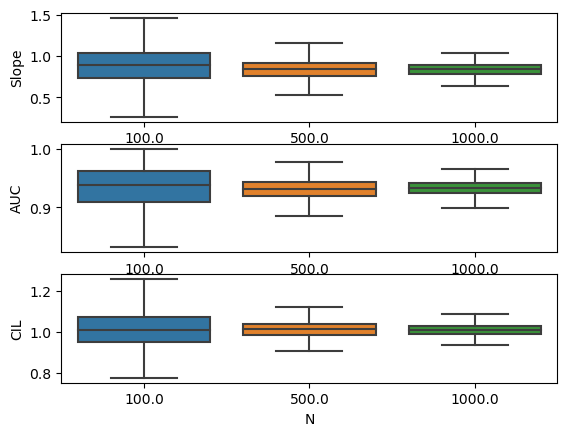

In [5]:
import matplotlib

#matplotlib.use("Agg")
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy import stats
import os
import sys
import time

# CONSTANTS
# put whatever your local directory is that has your files from SSAML
mydir = '/Users/danisized/Documents/GitHub/SSAML/OUTcovaFAKE/'
# Note, the numLIST numbers here are hard coded for the number of patients/events we tested. 
# change to whatever you like here
numLIST = [100,500,1000]

# FUNCTION DEFINITIONS
def getZING(prefixN,middleOne,numLIST):
  # load up the ZING files and compose a pandas dataframe from it
  print('Loading %s...' % prefixN)
  
  for howmany in numLIST:
    fn = prefixN + str(howmany).zfill(4) + '.csv'
    dat = pd.read_csv(fn,sep=',',header=None)
    dat.columns =['Slope',middleOne,'CIL']
    dat['N'] = dat.Slope*0 + howmany
    if howmany == numLIST[0]:
      bigD = dat
    else:
      bigD = bigD.append(dat,ignore_index=True)
  return bigD

def plotZING(prefixN,numLIST):
    # the ZING files allow the detailed boxplots or violin plots to be displayed

    useme = 'AUC'

    # fill a pandas dataframe with slope, c-index/auc and cil
    for howmany in numLIST:
        fn = prefixN + str(howmany).zfill(4) + '.csv'
        dat = pd.read_csv(fn,sep=',',header=None)
        dat.columns =['Slope',useme,'CIL']
        dat['N'] = dat.Slope*0 + howmany
        if howmany == numLIST[0]:
            bigD = dat
        else:
            bigD = bigD.append(dat,ignore_index=True)

    # draw a boxplot for each of the 3 metrics, save as a file with 300 dpi
    fig, (ax1, ax2, ax3) = plt.subplots(3,1)
    plt.subplot(3,1,1)
    ax1 = sns.boxplot(x="N", y="Slope", data=bigD,showfliers=False)
    plt.subplot(3,1,2)
    ax2 = sns.boxplot(x="N", y=useme, data=bigD,showfliers=False)
    plt.subplot(3,1,3)
    ax3 = sns.boxplot(x="N", y="CIL",data=bigD,showfliers=False)

    return


# MAIN
os.chdir(mydir)

bigD = getZING('smallZ','C-index',numLIST)
print('plotting...')

plotZING('smallZ',numLIST)
plt.show()